In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns


In [2]:
# Set path to dataset folder
data_dir = 'dataset'  # This works now because the folder exists!

# Image properties
img_height = 128
img_width = 128
batch_size = 32

# Load training data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Load validation data
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.


Class Names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


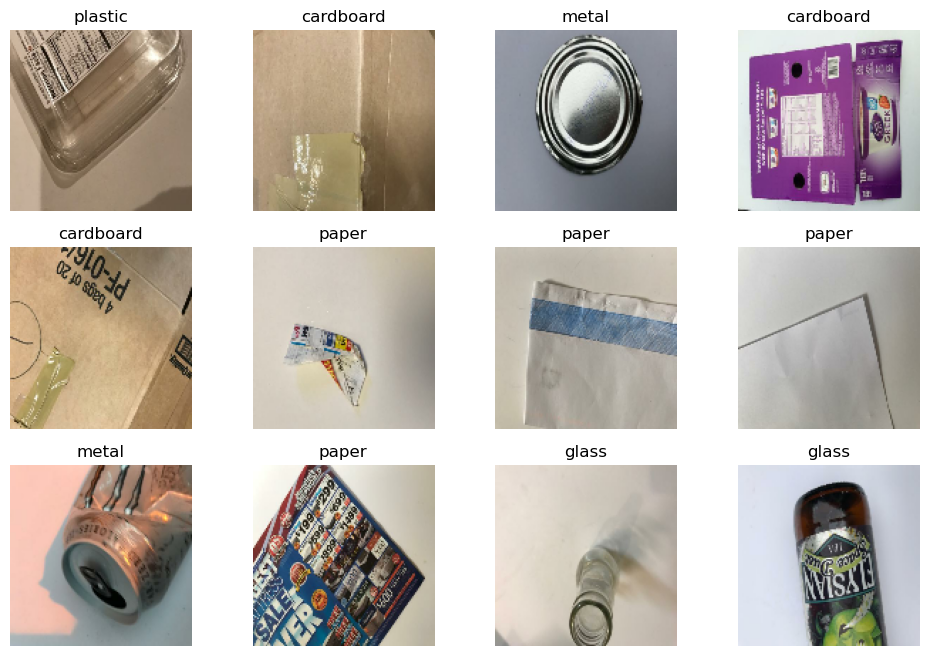

In [3]:
# View class names
class_names = train_ds.class_names
print("Class Names:", class_names)

# Plot some sample images from training dataset
plt.figure(figsize=(12, 8))
for images, labels in train_ds.take(1):  # take 1 batch
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

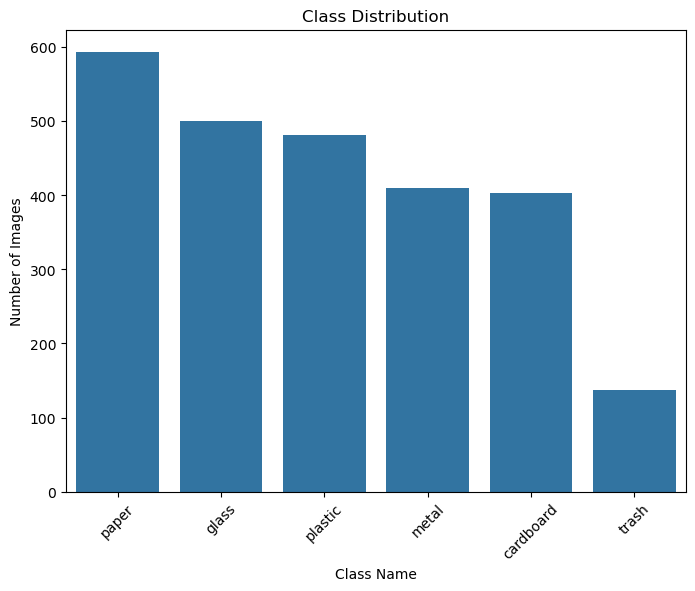

           Image Count
paper              594
glass              501
plastic            482
metal              410
cardboard          403
trash              137


In [4]:
import os
import pandas as pd

# Path to dataset
data_path = 'dataset'

# Count images per class
class_counts = {}
for class_name in os.listdir(data_path):
    class_path = os.path.join(data_path, class_name)
    if os.path.isdir(class_path):
        count = len(os.listdir(class_path))
        class_counts[class_name] = count

# Show class distribution
df = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Image Count'])
df = df.sort_values(by='Image Count', ascending=False)

# Plot class distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=df.index, y=df['Image Count'])
plt.title("Class Distribution")
plt.ylabel("Number of Images")
plt.xlabel("Class Name")
plt.xticks(rotation=45)
plt.show()

print(df)

In [5]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Extract class names
class_names = train_ds.class_names
print("Classes:", class_names)

# Count number of images per class again
num_images_per_class = []
for class_name in class_names:
    folder = os.path.join(data_path, class_name)
    num_images = len(os.listdir(folder))
    num_images_per_class.append(num_images)

# Convert class labels to integers (0 to 5)
class_indices = np.arange(len(class_names))

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=class_indices,
    y=np.repeat(class_indices, num_images_per_class)
)

# Convert to dictionary
class_weights_dict = dict(zip(class_indices, class_weights))

# Show class weights
print("\nComputed Class Weights:")
for i, weight in class_weights_dict.items():
    print(f"{class_names[i]}: {weight:.2f}")

Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

Computed Class Weights:
cardboard: 1.05
glass: 0.84
metal: 1.03
paper: 0.71
plastic: 0.87
trash: 3.07


In [6]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Data Augmentation Layer
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Prefetch for performance boost
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=AUTOTUNE
)

# Prefetching for training performance
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

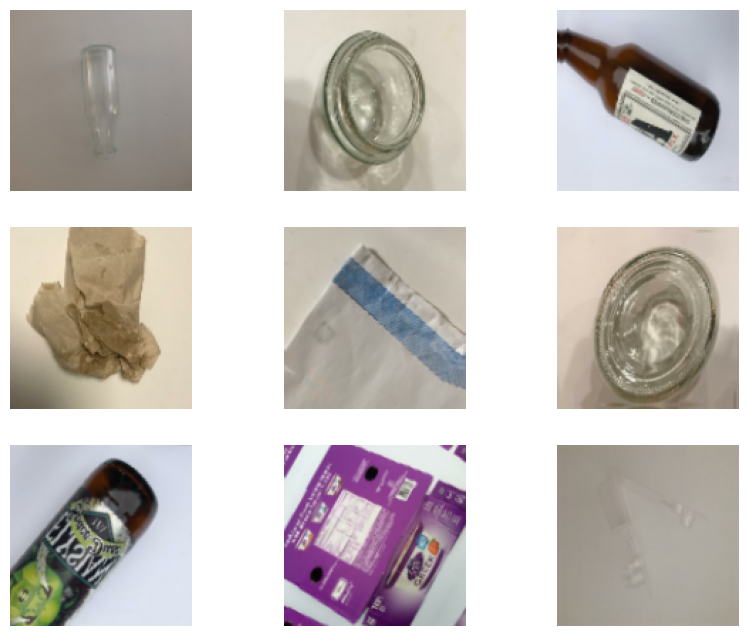

In [7]:
# See augmented images from one batch
for images, _ in train_ds.take(1):
    plt.figure(figsize=(10, 8))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
    break

In [8]:
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# Load EfficientNetV2B2 with pretrained weights
base_model = EfficientNetV2B2(
    include_top=False,  # We’ll add our own classifier
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)

# Freeze the base model (initial training phase)
base_model.trainable = False

# Build the full model
inputs = Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)  # Optional, for more augmentation
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(len(class_names), activation='softmax')(x)
model = Model(inputs, outputs)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Show model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 4, 4, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         8,454 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,777,828 (33.48 MB)

 Trainable params: 8,454 (33.02 KB)

 Non-trainable params: 8,769,374 (33.45 MB)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop],
    class_weight=class_weights_dict
)

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.3511 - loss: 1.5675 - val_accuracy: 0.7327 - val_loss: 0.8660
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 43s 671ms/step - accuracy: 0.6871 - loss: 0.9121 - val_accuracy: 0.7782 - val_loss: 0.7038
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 53s 807ms/step - accuracy: 0.7323 - loss: 0.7517 - val_accuracy: 0.8020 - val_loss: 0.6270
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 51s 780ms/step - accuracy: 0.7511 - loss: 0.6947 - val_accuracy: 0.8000 - val_loss: 0.6040
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 55s 853ms/step - accuracy: 0.7836 - loss: 0.6204 - val_accuracy: 0.8040 - val_loss: 0.5842
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 639ms/step - accuracy: 0.7670 - loss: 0.6209 - val_accuracy: 0.8000 - val_loss: 0.5728
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 628ms/step - accuracy: 0.8086 - loss: 0.5562 - val_accuracy: 0.7960 - val_loss: 0.5693
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 44s 675ms/step - accuracy: 0.7879 - loss: 0.5779 - val_accura

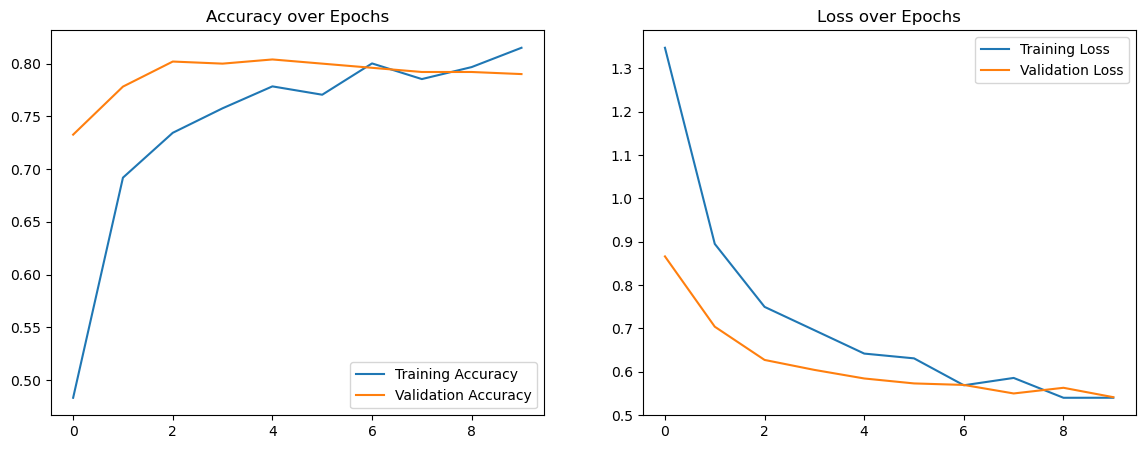

In [10]:
# Plot accuracy & loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 798ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


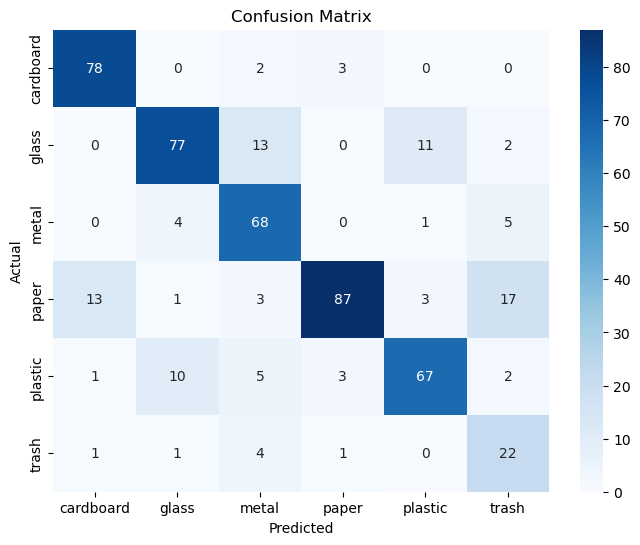

Classification Report:

              precision    recall  f1-score   support

   cardboard       0.84      0.94      0.89        83
       glass       0.83      0.75      0.79       103
       metal       0.72      0.87      0.79        78
       paper       0.93      0.70      0.80       124
     plastic       0.82      0.76      0.79        88
       trash       0.46      0.76      0.57        29

    accuracy                           0.79       505
   macro avg       0.76      0.80      0.77       505
weighted avg       0.81      0.79      0.79       505



In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Step 1: Get true labels and predictions
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

# Step 2: Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Step 3: Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

In [12]:
# Save in modern Keras format
model.save("garbage_classifier_model.keras")

In [13]:
from tensorflow.keras.models import load_model

# Try loading the saved model
model_loaded = load_model("garbage_classifier_model.keras")

print("Model loaded successfully ✅")

Model loaded successfully ✅
